In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


In [2]:
# inline plotting instead of popping out
%matplotlib inline

sns.set(style = 'whitegrid', context = 'notebook')

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


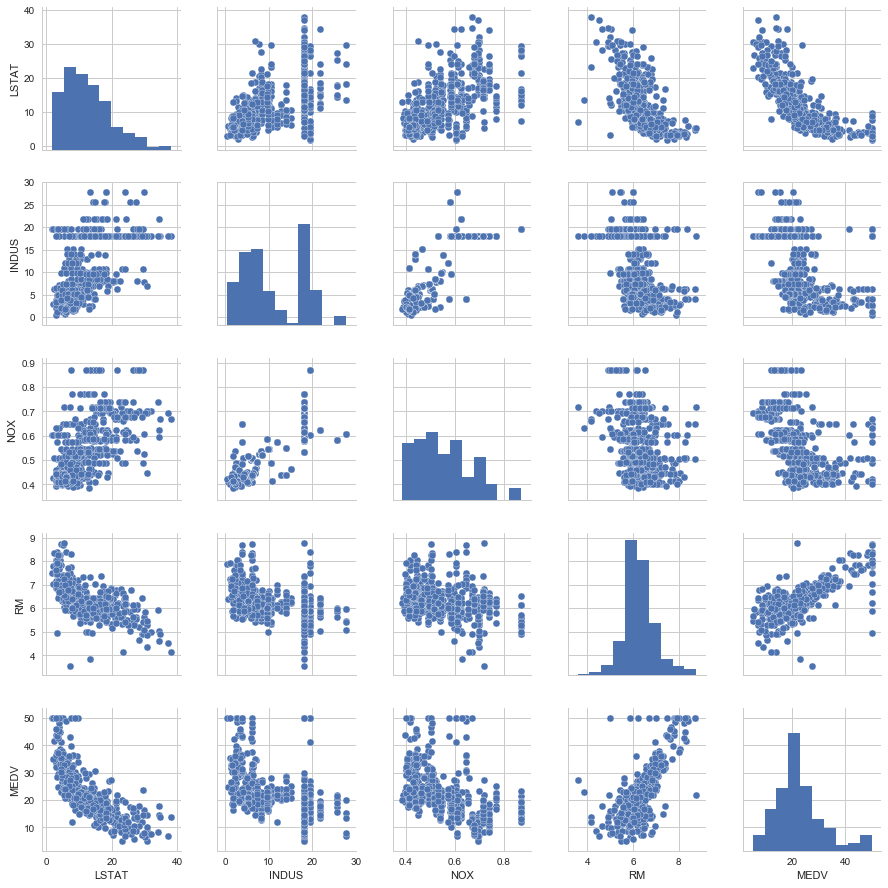

In [4]:
# for readability, we only plot five attributes
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size = 2.5)
plt.tight_layout()
#plt.savefig('./output/fig-housing-pairwise-dist.png', dpi=300)
plt.show()
sns.reset_orig()

### LinearRegression

In [5]:
# X, y
X_rm = df['RM'].values[:, np.newaxis]
y = df['MEDV'].values

In [6]:
slr = LinearRegression()
slr.fit(X_rm, y)

y_pred = slr.predict(X_rm)

print('Slope (w_1): %.2f' % slr.coef_[0])
print('Intercept/bias (w_0): %.2f' % slr.intercept_)

Slope (w_1): 9.10
Intercept/bias (w_0): -34.67


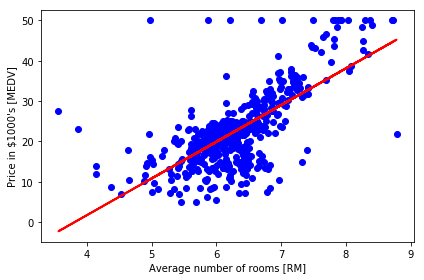

In [7]:
# To simplify our codes, predefine a function to visualize to regression line and data scatter plot.
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue') #真實值
    plt.plot(X, model.predict(X), color='red', linewidth=2) #回歸線
    return 

lin_regplot(X_rm, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
#plt.savefig('./output/fig-linreg-scikit-rm.png', dpi=300)
plt.show()

### 13個變數一起做回歸

In [9]:
X = df.iloc[:, :-1].values
print("size of features of X :", X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points : %d' % X_test.shape[0])

# Standardization
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training
slr = LinearRegression()
slr.fit(X_train_std, y_train)

# Testing
y_train_pred = slr.predict(X_train_std)
y_test_pred = slr.predict(X_test_std)

print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))


size of features of X : 13
#Training data points: 354
#Testing data points : 152
MSE train: 19.96, test: 27.20
R^2 train: 0.76, test: 0.67


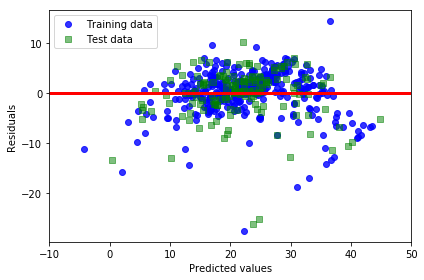

In [10]:
# Residuals
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='blue', marker='o', label='Training data', alpha = 0.8)
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='green', marker='s', label='Test data', alpha = 0.5)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.hlines(y = 0, xmin = -10, xmax = 50, lw = 3, color = 'red')
plt.xlim([-10, 50])
plt.tight_layout()
#plt.savefig('./output/fig-linreg-scikit-residuals.png', dpi=300)
plt.show()

### LinearRegressionGD

In [11]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20, random_state = 1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

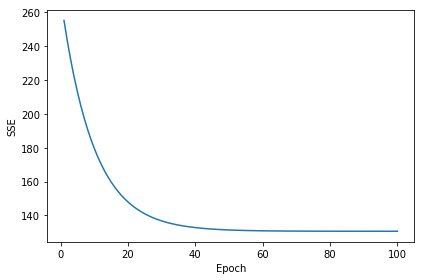

In [12]:
# StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_rm_std = sc_x.fit_transform(X_rm)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD(eta = 0.0001, n_iter = 100)
lr.fit(X_rm_std, y_std)

plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
#plt.savefig('./output/fig-linreg-gd-cost.png', dpi=300)
plt.show()

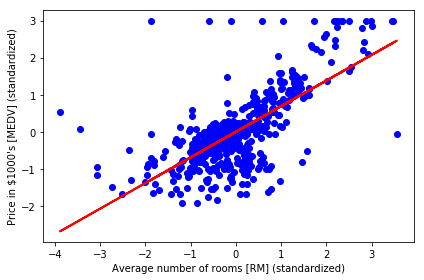

In [13]:
lin_regplot(X_rm_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
#plt.savefig('./output/fig-linreg-gd-rm.png', dpi=300)
plt.show()

### 用LinearRegression去對 lin, quad and cubic特性的變數做回歸

(506, 1)


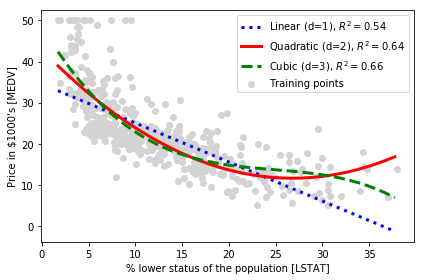

In [14]:
X_lin = df['LSTAT'].values[:, np.newaxis]
print(X_lin.shape)

regr = LinearRegression()

# Create quadratic features
quadratic = PolynomialFeatures(degree = 2)
cubic = PolynomialFeatures(degree = 3)
X_quad = quadratic.fit_transform(X_lin) # dim=3(121)
X_cubic = cubic.fit_transform(X_lin) # dim=4(1331)

# fit features
X_fit = np.arange(X_lin.min(), X_lin.max(), 1)[:, np.newaxis]

regr = regr.fit(X_lin, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X_lin))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X_lin, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label = 'Linear (d=1), $R^2=%.2f$' % linear_r2, 
         color = 'blue', 
         lw = 3, 
         linestyle = ':')

plt.plot(X_fit, y_quad_fit, 
         label = 'Quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color = 'red', 
         lw = 3,
         linestyle = '-')

plt.plot(X_fit, y_cubic_fit, 
         label = 'Cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color = 'green', 
         lw = 3, 
         linestyle = '--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
#plt.savefig('./output/fig-polyreg-degree.png', dpi=300)
plt.show()

In [19]:
regr = LinearRegression()

print('[Linear]')
print('#Features: %d' % X_train.shape[1])
regr = regr.fit(X_train, y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)
print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

print('\n[Quadratic]')
X_quad_train = quadratic.fit_transform(X_train)
X_quad_test = quadratic.fit_transform(X_test)
print('#Features: %d' % X_quad_train.shape[1])
regr = regr.fit(X_quad_train, y_train)
y_train_pred = regr.predict(X_quad_train)
y_test_pred = regr.predict(X_quad_test)
print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

print('\n[Cubic]')
X_cubic_train = cubic.fit_transform(X_train)
X_cubic_test = cubic.fit_transform(X_test)
print('#Features: %d' % X_cubic_train.shape[1])
regr = regr.fit(X_cubic_train, y_train)
y_train_pred = regr.predict(X_cubic_train)
y_test_pred = regr.predict(X_cubic_test)
print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))


[Linear]
#Features: 13
MSE train: 19.96, test: 27.20
R^2 train: 0.76, test: 0.67

[Quadratic]
#Features: 105
MSE train: 4.12, test: 29.00
R^2 train: 0.95, test: 0.65

[Cubic]
#Features: 560
MSE train: 0.00, test: 85912.08
R^2 train: 1.00, test: -1030.78


### 利用決策樹做分類

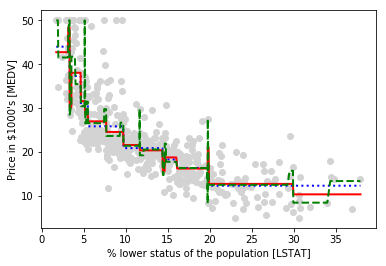

In [20]:
tree_3 = DecisionTreeRegressor(max_depth=3)
tree_3.fit(X_lin, y)
tree_4 = DecisionTreeRegressor(max_depth=4)
tree_4.fit(X_lin, y)
tree_5 = DecisionTreeRegressor(max_depth=5)
tree_5.fit(X_lin, y)

sort_idx = X_lin.flatten().argsort()

plt.scatter(X_lin, y, color='lightgray')

plt.plot(X_lin[sort_idx], tree_3.predict(X_lin)[sort_idx],         
         color='blue', 
         lw=2, 
         linestyle=':')
plt.plot(X_lin[sort_idx], tree_4.predict(X_lin)[sort_idx], 
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_lin[sort_idx], tree_5.predict(X_lin)[sort_idx], 
         color='green', 
         lw=2, 
         linestyle='--')


plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
#plt.savefig('./output/fig-treereg-depth.png', dpi=300)
plt.show()

MSE train: 1.41, test: 14.31
R^2 train: 0.98, test: 0.83


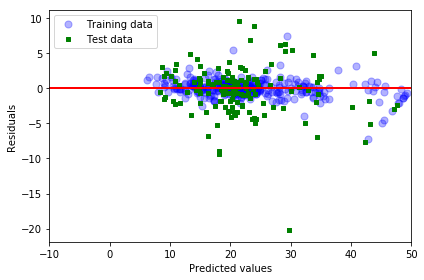

In [21]:
forest = RandomForestRegressor(n_estimators = 3000, 
                               criterion = 'mse', 
                               random_state = 1, 
                               n_jobs = -1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))

# Residual plot
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c = 'blue', 
            marker = 'o',
            label = 'Training data',
            alpha = 0.3, s = 50)
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c = 'green', 
            marker = 's',
            label = 'Test data',
            alpha = 1.0, s = 10)

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
#plt.savefig('./output/fig-forestgre-residuals.png', dpi=300)
plt.show()
